# Makemore Part:3 - Activations & Gradients, BatchNorm

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
# print(itos)
# print(vocab_size)

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / (n_embd * block_size)**0.5) # *0.2
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [7]:
# same optimization as last time
max_steps = 200001
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
    # Batch normalization layer
    # -------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # ------------------------------------------------------------------------
    # Non-linearity layer
    h = torch.tanh(hpreact) # Hidden layer
    logits = h @ W2 + b2 # Output layer
    loss = F.cross_entropy(logits, Yb) # Loass function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200001: 3.3239
  10000/ 200001: 2.0322
  20000/ 200001: 2.5675
  30000/ 200001: 2.0125
  40000/ 200001: 2.2446
  50000/ 200001: 1.8897
  60000/ 200001: 2.0785
  70000/ 200001: 2.3681
  80000/ 200001: 2.2918
  90000/ 200001: 2.0238
 100000/ 200001: 2.3673
 110000/ 200001: 2.3132
 120000/ 200001: 1.6414
 130000/ 200001: 1.9311
 140000/ 200001: 2.2231
 150000/ 200001: 2.0027
 160000/ 200001: 2.0997
 170000/ 200001: 2.4949
 180000/ 200001: 2.0199
 190000/ 200001: 2.1707
 200000/ 200001: 2.1862


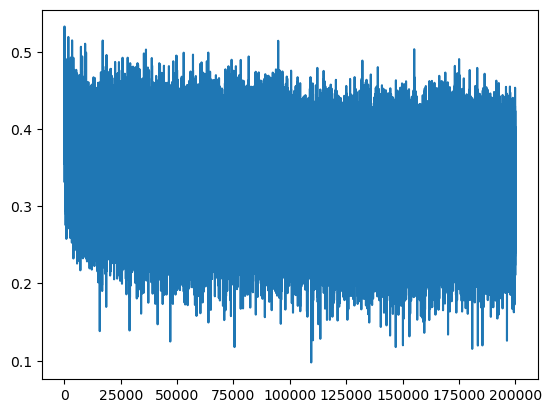

In [8]:
plt.plot(lossi)
plt.show()

In [9]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    ## Pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    # Measure the mean/std over the entire trainng set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
# But instead of doing this seperately after the training why not do it during the training

In [10]:
@torch.no_grad() # this decorator disables gradient tracking; shows that we won't call backward on this, and this will be a bit efficient
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # Hidden layer
    logits = h @ W2 + b2 # Output layer
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.067310333251953
val 2.1055850982666016


### LOSS LOG

#### # Original
train 2.1245\
val 2.1684

#### # Fix softmax confidently wrong / initial loss fix
train 2.07\
val 2.13

#### # Fix tang layer too saturated at init
train 2.0343780517578125\
val 2.1024086475372314

#### # Using Kaiming init for W1
train 2.0376641750335693\
val 2.1069891452789307

#### # After batch normalization
train 2.0718953609466553\
val 2.108823299407959

In [46]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # Initialize all with ...
    while True:
        # Forward pass of the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        h = torch.tanh(emb.view(emb.shape[0], -1) @ W1) #+ b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

cathlifatubhl.
khlimrithlitslestadsh.
jazhmirfardsthciarquifneffarrichrishduslafgyufbmghziriqustzishlistan.
vabiusstell.
diarisix.
khegzifsabbud.
zaiirsgyasluysfaadhlanyivariksyah.
maboubzettr.
jesiahasdannakphladlummygotberksiaghubniq.
qlylianaysh.
xeinahqueld.
bldn.
tdy.
madthgb.
sphlynanyasislytte.
conzabbuljadak.
khlesdanikosmuseff.
kyaq.
blustre.
boktnyah.


## Fixing the initial loss

In [14]:
# We got an initial loss of 26.5 at iteration 0
# We can make an educated guess of the loss at iteration 0
# The probability of any char we should record should be 1/27
# So the negative log probability we should expect is
-torch.tensor(1/27).log()

tensor(3.2958)

In [15]:
# 4D example of the issue
#logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([3.2946e-05, 4.9370e-11, 6.4469e-03, 9.9352e-01]), tensor(5.0442))

In [16]:
# Here we have a uniform distribuition, if by chance 1 of the logits had a higher number
# And we chose that coincidently to calculate loss, then the probability would be low

In [17]:
# Solution is we multiply b2 * 0 at initialization
# And W2 * 0.1 or 0.01; so that the logits will be closer to 0
# And we don't want to set W2 to 0 initially

## Fixing the saturated tanh

In [18]:
# The logits are now okay but he problem now is with h
# Many of the elements of h are 1 or -1

In [43]:
# plt.hist(h.view(-1).tolist(), 50)
# plt.show()

In [22]:
# plt.hist(hpreact.view(-1).tolist(), 50)
# plt.show()

In [23]:
# Using tanh, squashes the hpreact to be between 1 and -1; but with
# Most of the values being in the middle of the histogram of hpreact in the above fig
# The h will mostly consist of -1 and 1 
# And this is a big problem

In [24]:
# Tanh during backprop is (1 - t**2) * out.grad 
# if t becomes 0, 1 or -1; the backprop for that value basically stops as our grad becomes
# Stagnant 
# So when t = 0; we get 1 * out.grad
# When t = 1 or -1; we get just out.grad

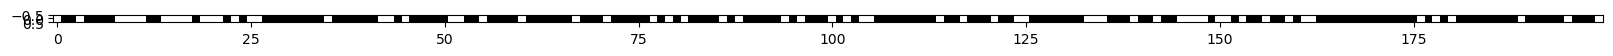

In [42]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.show()

In [26]:
# Boolean tensor; white if true, lack if false
# White means the tanh neurons are in a flat tail, close to 1 or -1 in this case 
# Since we checked for (-1) and in all these cases the backward gradient get's destroyed
# Here none of the neurons are completely dead; all of them activate most of the time

In [27]:
# Solution is we change the tanh activation function to something else or 
# hpreact to be closer to 0
# We multiplied both W1 with 0.2 and h1 with 0.01
# With these changes we get a good output

In [28]:
# Now let's run the full optimization and see the loss

## Calculating the init scale: "Kaiming init"

In [29]:
# Now how we got these numbers of 0.2, 0.01 - magic numbers we used in the weights and biases intialization.
# The question is how do we preserve the W to be the same Gaussian even after activation?
# The figure below shows a Gaussian that grows
# If we multiply w with a large number, the Gaussian keeps growing
# That means the numbers on the y-axis of the right side figure take more extreme values
# 
# So the question is by what do we multiply w so that we exactly preserve the standard deviation of y to be 1 
# The solution is that we divide by the square root of the number of input elements
# We also need to add a gain to it after the division

tensor(-0.0022) tensor(1.0181)
tensor(0.0025) tensor(0.9967)


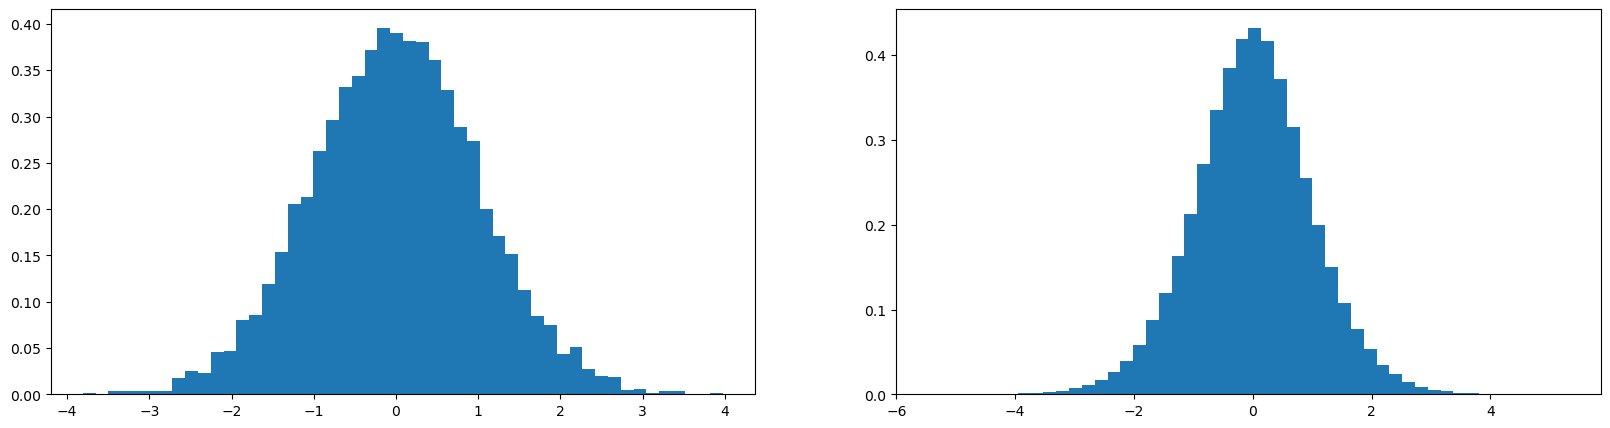

In [30]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w 
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
plt.show()

In [31]:
(torch.randn(10000).std())
# The standard deviation of this is 1 but if we do this
(torch.randn(10000) * 0.2) .std()
# The std becomes 0.2; so the std is whatever we multiply it by
# Therefore in the above init of the weights, the std of W1 became 0.2

tensor(0.2025)

In [32]:
# The std = gain / sq root of fan in (the input dimensions)
# The gain for tanh according to pytorch documentation is 5/3 
# input dimensions is 10 in this exapmle

## Batch Normalization

In [33]:
# We want hpreact to be Gaussian, but they can be too low to impact the tanh or too high to saturate it
# SO the solution is that we take the hidden states and normalize them to be Gaussian.

In [34]:
# The shape of hpreact is 32, 200
# We use the mean and standard deviation to normalize it column-wise

In [35]:
# But there is a problem; we want them to be Gaussian only at the time of init, not always
# So we need to scale them by a gain(1) and add a bias(0); both of shape 1, no_hidden

In [36]:
# Later during backprop they will be trained; so add them to the parameter list

In [37]:
# But batch normalization comes at a terrible cost
# We did calculations in batches to improve efficiency but because of batch normalization, 
# we are coupling these examples in the forward and backward pass mathematically
# Therefore the logits produced are not of a single example but of other examples which got attached to it, sampled randomly
# This is not a bug as it turns out to be good in neural network training as a side effect
# works as a regularizer; form of data augmentation; so makes it harder to overfit

In [38]:
# The batch norm expects the input to be in batches so we need to 
# Calibrate the batch norm at the end of the training to set the batch norm, mean and deviation
# a single time over the entire training set

In [39]:
# The b1 added to the hpreact is useless as it is being subtracted in the batch norm
# Since batch norm has its own bias, there is no need to add one in the layer before it

In [40]:
# Summary: using it to control the statistics of the activations in the neural net; 
# Common to sprinkle batch norm layer throughout the neural net
# Usually placed after the layers that have multiplication like a linear or convolutional layer
# Internally has parameters for gain and bias which is trained using the backprop
# It also has 2 buffers, mean and standard deviation 

## Real Example: resnet50 walkthrough 

In [41]:
# Residual neural net; common types used for image classification
# Read it on google
# Conv -> batch norm -> relu
# So compared to our network it is
# Weight layer -> normalization layer -> non-linearity layer

## PART 2: PyTorch-ifying the code

In [49]:
# Let's train a deeper network
# The network is remade here

In [15]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
          self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
    # calculate the forward pass
        if self.training:
          xmean = x.mean(0, keepdim=True) # batch mean
          xvar = x.var(0, keepdim=True) # batch variance
        else:
          xmean = self.running_mean
          xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
          with torch.no_grad():
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 # 5/32

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [16]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps+1):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 1.0 # 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    # if i >= 1000:
    #      break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870
  10000/ 200000: 2.3593
  20000/ 200000: 2.1601
  30000/ 200000: 2.1586
  40000/ 200000: 2.2735
  50000/ 200000: 2.2420
  60000/ 200000: 1.7262
  70000/ 200000: 2.1799
  80000/ 200000: 2.3887
  90000/ 200000: 2.0485
 100000/ 200000: 2.4276
 110000/ 200000: 2.2445
 120000/ 200000: 2.2677
 130000/ 200000: 1.9319
 140000/ 200000: 1.6803
 150000/ 200000: 1.9402
 160000/ 200000: 2.1262
 170000/ 200000: 1.9568
 180000/ 200000: 2.3132
 190000/ 200000: 1.9745
 200000/ 200000: 2.1604


layer 2 (      Tanh): mean -0.03, std 0.78, saturated: 31.97%
layer 5 (      Tanh): mean -0.02, std 0.80, saturated: 28.50%
layer 8 (      Tanh): mean -0.04, std 0.81, saturated: 31.12%
layer 11 (      Tanh): mean -0.02, std 0.83, saturated: 35.78%
layer 14 (      Tanh): mean +0.03, std 0.85, saturated: 43.81%


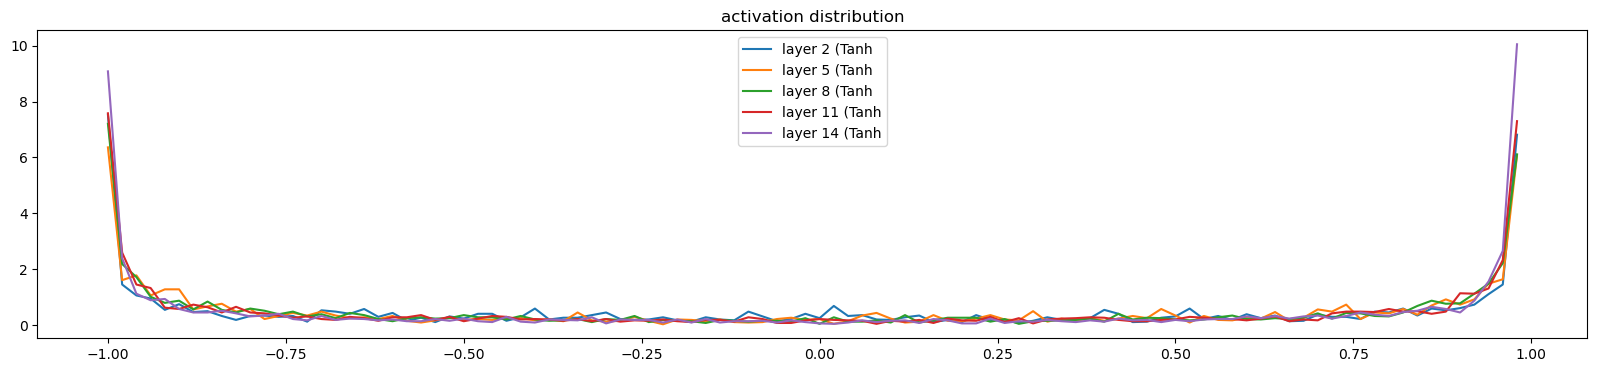

In [17]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')
plt.show()

layer 2 (      Tanh): mean +0.000000, std 4.117346e-03
layer 5 (      Tanh): mean +0.000000, std 4.248375e-03
layer 8 (      Tanh): mean -0.000000, std 3.837960e-03
layer 11 (      Tanh): mean +0.000000, std 3.273475e-03
layer 14 (      Tanh): mean -0.000000, std 3.917019e-03


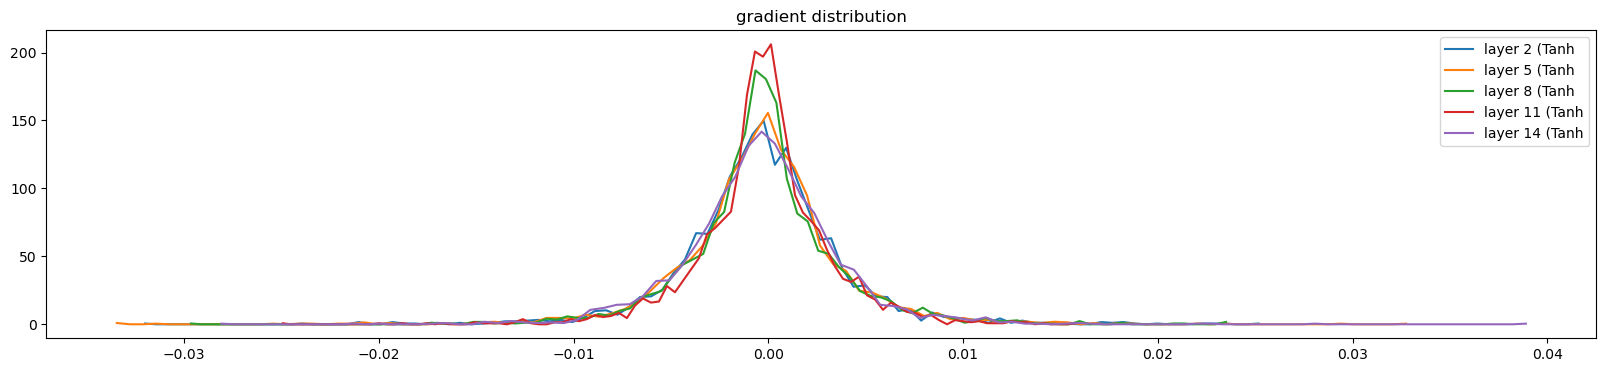

In [18]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')
plt.show()

weight   (27, 10) | mean +0.000000 | std 5.445948e-03 | grad:data ratio 1.675446e-03
weight  (30, 100) | mean -0.000060 | std 2.627888e-03 | grad:data ratio 1.617550e-03
weight (100, 100) | mean -0.000006 | std 1.528291e-03 | grad:data ratio 1.298184e-03
weight (100, 100) | mean -0.000014 | std 1.536866e-03 | grad:data ratio 1.322691e-03
weight (100, 100) | mean -0.000002 | std 1.260381e-03 | grad:data ratio 1.109391e-03
weight (100, 100) | mean +0.000001 | std 1.079368e-03 | grad:data ratio 9.653660e-04
weight  (100, 27) | mean -0.000031 | std 2.182589e-03 | grad:data ratio 1.544053e-03


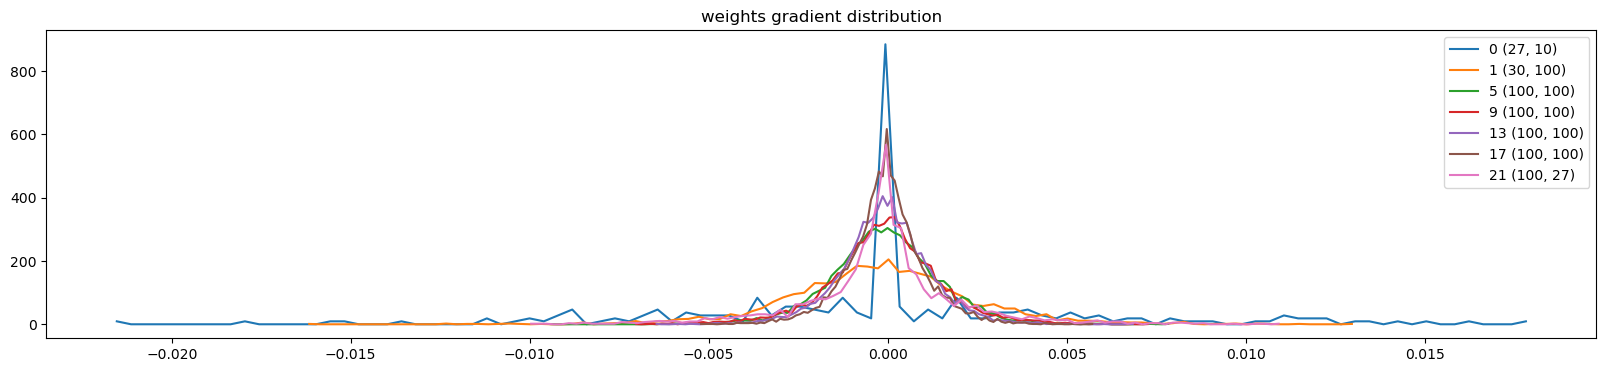

In [19]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


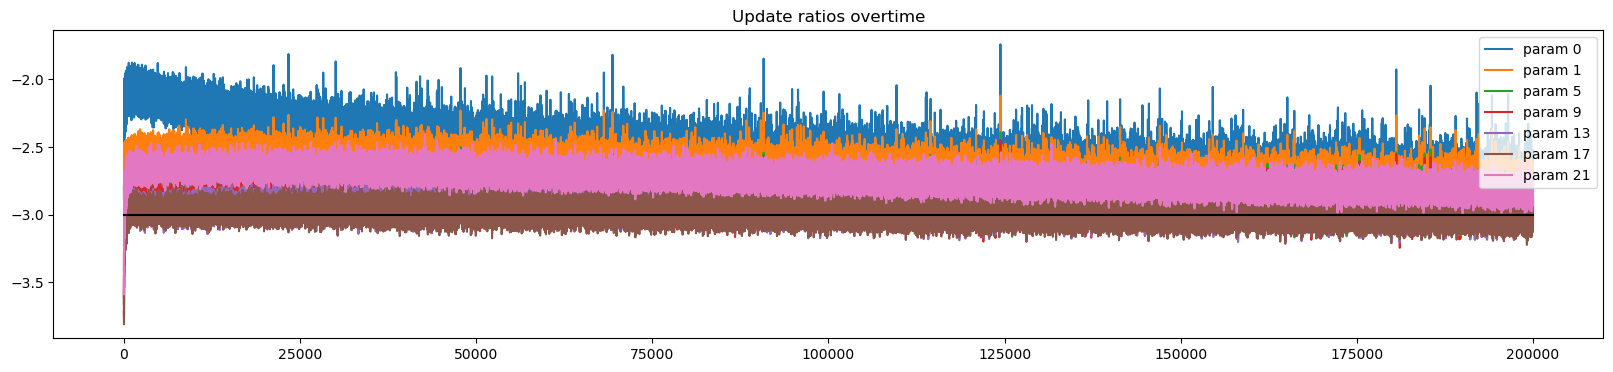

In [20]:

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title('Update ratios overtime')
plt.show()

In [21]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.0691306591033936
val 2.1347110271453857


In [22]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmahela.
jhovi.
kimri.
ree.
cassa.
sane.
rah.
bradhery.
chareei.
nellara.
chaiir.
kaleigh.
ham.
ford.
quinton.
lilah.
jadalyn.
jero.
dearistick.
evairuly.
